<a href="https://colab.research.google.com/github/MSaber9/Machine-Learning/blob/master/BayesianOptimizationv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequential Model Based Optimisation - SMBO Optimizer

Implement the SMBO optimizer:
-	Use the Gaussian processes and Random Forest as a surrogate function. Use random search as baseline method.
-	Compare these three methods with each other. 
- Build a graph of the minimum found value versus the number of calls of the optimized function.
-	Use the Rastrigin Function as a test function.


### Introduction

> **Surrogate model** - The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement.

>  **Acquisition functions** - Proposing sampling points in the search space is done by acquisition functions. They trade off exploitation and exploration. 
- Exploitation means sampling where the surrogate model predicts a high objective and 
- Exploration means sampling at locations where the prediction uncertainty is high

> Using:
- Maximum probability of improvement (MPI)
- Expected improvement (EI)
- Upper confidence bound (UCB)



## Library 

In [1]:
pip install bayesian-optimization

In [0]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

## Rastrigin Function

the Rastrigin function is a non-convex function used as a performance test problem for optimization algorithms. 

In [0]:
X = np.linspace(-10, 10, 100)     
Y = np.linspace(-10, 10, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
# m = m + X(i)^2 - A*cos(2*pi*X(i));

## Random Search

- Is numerical optimization methods, not require the gradient of the problem to be optimized
- RS is attributed to Rastrigin

In [0]:
BasicA = np.arange(-10,10,0.01)
BasicZ = np.arange(0,1000,0.1)
epochs = 100

In [0]:
def ValueZ(BasicA):
    X = np.random.choice(BasicA,1)
    Y = np.random.choice(BasicA,1)
    Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
    return Z

In [0]:
def RandomSearch (n_times):
    RsList = [] 
    for i in range(n_times):
        valueList = []
        min_Z = np.random.choice(BasicZ,1)
        
        for i in range(epochs):
            Z = ValueZ (BasicA)
            valueList.append(Z)
            if min_Z > Z: # Target
                min_Z = Z
            else:
                pass
        RsList.append(valueList)
    return RsList


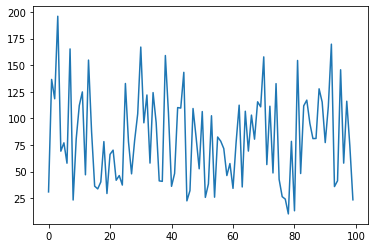

In [7]:
RandomSearch = RandomSearch(10)
axis_X = range(epochs)
plt.figure()
plt.plot(axis_X,RandomSearch [0])
plt.show()

## RFGP

Build Random Forest Processing and Gaussian Process Processing Model

In [0]:
def initialization(BasicA,n_samples):

    X_initial = []
    Y_initial = []

    for i in range(n_samples):
        X = np.random.choice(BasicA,1)
        Y = np.random.choice(BasicA,1)
        X_initial.append([X[0],Y[0]])
        Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 25
        Y_initial.append(Z)
        
    X_initial = np.array(X_initial)
    Y_initial = np.array(Y_initial)
    return X_initial,Y_initial

In [0]:
def RFGPEquation (X,X_sample, Y_sample,rf,tradeoff=0.1):
    predicts = rf.predict(X)
    mu, sigma = predicts.mean(), predicts.std() # Mean and covariance of the prior
    sigma = sigma + 1e-6 # Add Noise 

    mu_sample_opt = np.max(Y_sample)

    imp = mu - mu_sample_opt - tradeoff # Update mean Sample
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z) # expected improvement (EI)
    return ei

In [0]:
def FindZ(x_new):
    Z = (x_new[0]**2 - 10 * np.cos(2 * np.pi * x_new[0])) + (x_new[1]**2 - 10 * np.cos(2 * np.pi * x_new[1])) + 20
    return Z

In [0]:
def RFGP (n,fun):

    RFGPList = []
    for i in range(n):

        bounds = np.asarray([[-10,  10], [-10,  10]])
        RFGPValue = []

        if (fun == 'rf'):
          print('Random Forest Processing ....')
          RFGP = RandomForestRegressor(n_estimators=25)
        
        if (fun == 'gp'):
          print('Gaussian Process Processing ....')
          RFGP = GaussianProcessRegressor(kernel=Matern(nu=2.5), n_restarts_optimizer=9)


        X_initial,Y_initial = initialization(BasicA,5)
        min_Z = Y_initial[Y_initial.argmin()]

        RFGP.fit(X_initial,Y_initial)
        def min_obj(X):
            return -RFGPEquation (X.reshape(-1, 2),X_initial,Y_initial,RFGP)

        min_val = None
        min_x = None
        x_set =  np.random.uniform(bounds[:, 0], bounds[:, 1], size=(100, 2))

        # Find the best optimum by starting from n_restart different random points.
        for x0 in x_set: 
            res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
            if  min_val is None or res.fun < min_val:

                min_val = res.fun
                min_x = res.x
# -------------------------------------------------------------------------
        for i in range(epochs):
            new_Z = FindZ(min_x)
            RFGPValue.append(new_Z)

            if new_Z < min_Z:
                min_Z = new_Z

            X_initial = np.vstack((X_initial,min_x))
            Y_initial = np.vstack((Y_initial,new_Z))
            RFGP.fit(X_initial,Y_initial)
            min_val = None
            min_x = None
            x_set =  np.random.uniform(bounds[:, 0], bounds[:, 1], size=(100, 2))

            # Find the best optimum by starting from n_restart different random points.
            for x0 in x_set: 
                res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
                if  min_val is None or res.fun < min_val:

                    min_val = res.fun
                    min_x = res.x
        RFGPList.append(RFGPValue)
    return RFGPList

In [0]:
def RunModel(name,i):
  Model = RFGP(i,name)

  axis_X = range(epochs)
  plt.figure()
  plt.plot(axis_X,Model[0])
  plt.show()

  return Model

#### Random Forest Processing

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

Random Forest Processing ....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed whe

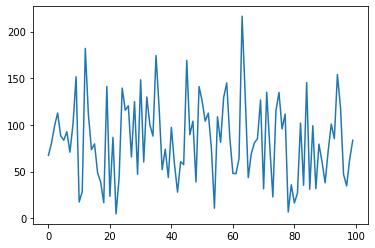

In [35]:
RandomForest = RunModel('rf',10)

### Gaussian Process Processing

Gaussian Process Processing ....


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Gaussian Process Processing ....


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Gaussian Process Processing ....
Gaussian Process Processing ....
Gaussian Process Processing ....
Gaussian Process Processing ....


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Gaussian Process Processing ....
Gaussian Process Processing ....


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Gaussian Process Processing ....
Gaussian Process Processing ....


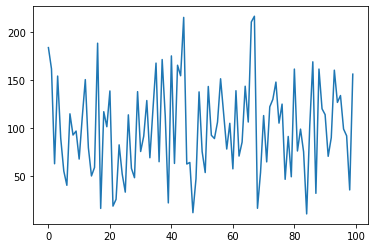

In [36]:
GuassianProc = RunModel('gp',10)

## Plot Minimum Models

In [0]:
def MinList(result):
    min_list = []
    min_val = result[0]
    #step = 0
    for i in range(epochs):
        val = result[i]
        if val < min_val:
            min_list.append(val)
            min_val = val
        else:
            min_list.append(min_val)
    return np.array(min_list)
    

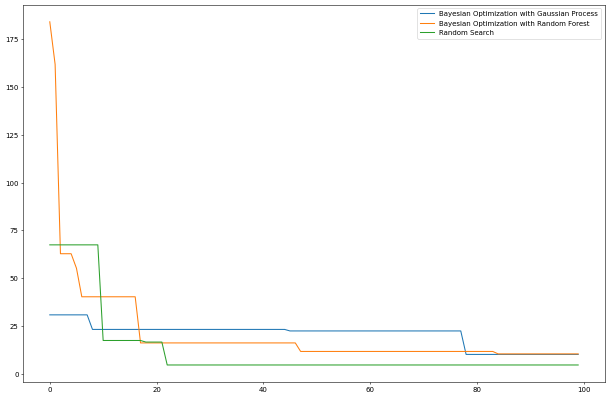

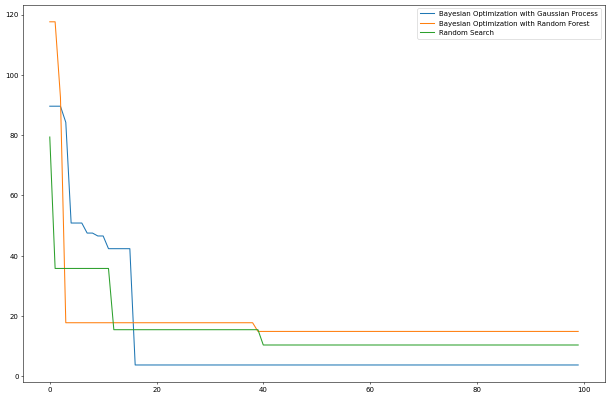

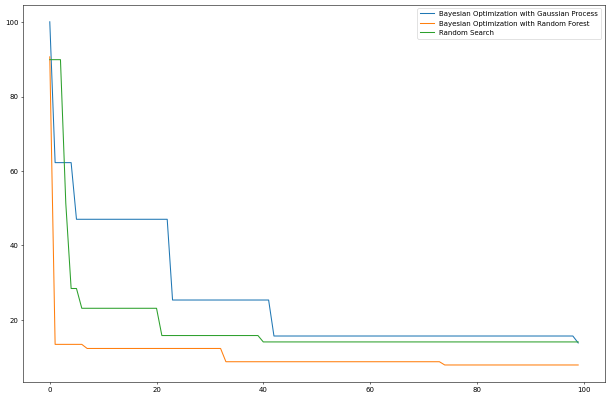

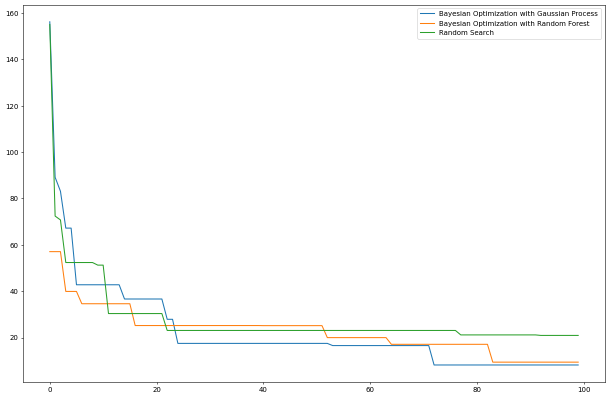

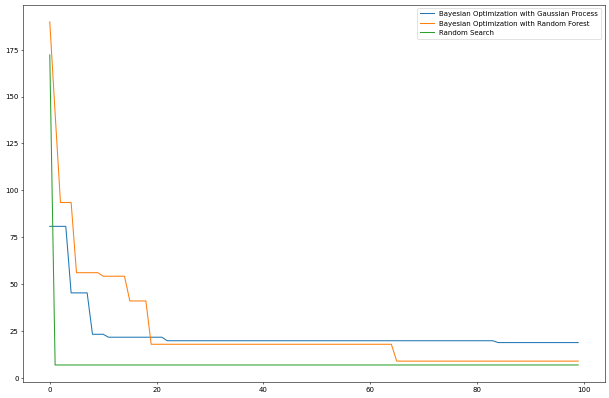

In [41]:
for i in range(5):
    axis_X = range(epochs)
    RsList = MinList (RandomSearch[i])
    GpList = MinList (GuassianProc[i])
    RfList = MinList (RandomForest[i])
    plt.figure(num=None, figsize=(15, 10), dpi=50)
    plt.plot(axis_X,RsList)
    plt.plot(axis_X,GpList)
    plt.plot(axis_X,RfList)
    plt.legend(["Bayesian Optimization with Gaussian Process",  "Bayesian Optimization with Random Forest",  "Random Search"])
    plt.show()

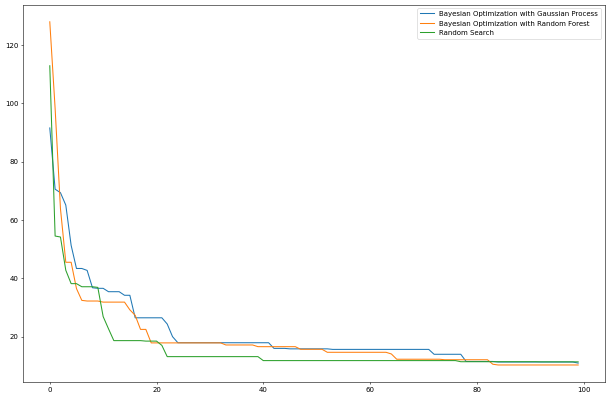

In [39]:
RsList = np.zeros((100,1))
GpList = np.zeros((100,1))
RfList = np.zeros((100,1))
for i in range(5):
    RsList += MinList (RandomSearch[i]).reshape(100,1)
    GpList += MinList (GuassianProc[i]).reshape(100,1)
    RfList += MinList (RandomForest[i]).reshape(100,1)
RsList = RsList/5
GpList = GpList/5
RfList = RfList/5

axis_X = range(epochs)
plt.figure(num=None, figsize=(15, 10), dpi=50)
plt.plot(axis_X,RsList)
plt.plot(axis_X,GpList)
plt.plot(axis_X,RfList)
plt.legend(["Bayesian Optimization with Gaussian Process", "Bayesian Optimization with Random Forest", "Random Search"])
plt.show()